## Import Libraries & Scripts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ParameterGrid
sns.set_style("darkgrid")
sns.set_palette("rainbow")
sns.set_context("talk")
from datetime import datetime

In [2]:
import sys  
sys.path.insert(0, r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\SCM\Baseline')

In [3]:
sys.path.insert(0, r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\SCM\SB3')

In [4]:
from agents import train_ddpg, train_td3, load_ddpg, load_td3, test_agent
import argparse

In [5]:
from SQPolicy import SQPolicy, simulate, simulate_episode
from Environment import SupplyChainEnvironment
from utils import visualize_transitions

In [6]:
from ax import optimize
import os

## Read data from local file

In [ ]:
df = pd.read_csv(r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\data\HistoricalProductDemand.csv")

In [ ]:
df["Date"] = pd.to_datetime(df["Date"]) # Convert Dates
df["Order_Demand"] = df["Order_Demand"].fillna(0).apply(lambda x: pd.to_numeric(x, errors='coerce')) # Convert to Float
df = df.dropna() # Remove rows with NaN

In [ ]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN

In [ ]:
df = df.sort_values(by=["Product_Code"])
product_codes = df["Product_Code"].drop_duplicates()

In [ ]:
counts = df.groupby("Product_Code").size()
counts = counts.to_dict()

In [ ]:
counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

In [ ]:
for idx, (k, v) in enumerate(counts.items()):
    print(f"{k}: {v}")
    
    if idx == 2:
        break

In [ ]:
demand_1359 = df[df["Product_Code"] == 'Product_1359'].drop(columns=["Product_Code", "Warehouse", "Product_Category"])
demand_1295 = df[df["Product_Code"] == 'Product_1295'].drop(columns=["Product_Code", "Warehouse", "Product_Category"])
demand_1378 = df[df["Product_Code"] == 'Product_1378'].drop(columns=["Product_Code", "Warehouse", "Product_Category"])

In [ ]:
demand_1359.sort_values(by="Date", inplace=True)
demand_1295.sort_values(by="Date", inplace=True)
demand_1378.sort_values(by="Date", inplace=True)

In [ ]:
demand_1359["Total_Demand"] = demand_1359.groupby("Date")["Order_Demand"].transform('sum')
demand_1295["Total_Demand"] = demand_1295.groupby("Date")["Order_Demand"].transform('sum')
demand_1378["Total_Demand"] = demand_1378.groupby("Date")["Order_Demand"].transform('sum')

In [ ]:
demand_1359.drop_duplicates(subset=["Date"], inplace=True)
demand_1359.drop(columns="Order_Demand", inplace=True)
demand_1359.set_index("Date", inplace=True)

demand_1295.drop_duplicates(subset=["Date"], inplace=True)
demand_1295.drop(columns="Order_Demand", inplace=True)
demand_1295.set_index("Date", inplace=True)

demand_1378.drop_duplicates(subset=["Date"], inplace=True)
demand_1378.drop(columns="Order_Demand", inplace=True)
demand_1378.set_index("Date", inplace=True)

In [ ]:
demand_1359

In [ ]:
final = pd.merge(demand_1359, demand_1295, on="Date")
final.rename({
    'Total_Demand_x': 'demand_1359',
    'Total_Demand_y': 'demand_1295',
}, axis='columns', inplace=True)

In [ ]:
final = pd.merge(final, demand_1378, on="Date")
final.rename({
    'Total_Demand': 'demand_1378'
}, axis='columns', inplace=True)
final
#demand_1378

In [ ]:
plt.figure(figsize=(9, 5))

f, ax = plt.subplots(1, 1, figsize=(16, 7))

ax.plot(final["demand_1359"], label="Product_1359")
ax.plot(final["demand_1295"], label="Product_1295")
ax.plot(final["demand_1378"], label="Product_1378")

ax.legend()

In [ ]:
demand_1359.to_csv(r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\data\demand_1359.csv")
demand_1295.to_csv(r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\data\demand_1295.csv")
demand_1378.to_csv(r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\data\demand_1378.csv")
final.to_csv(r"C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\data\demand.csv")

## 1 Plant - N warehouses

### User Defined Functions

In [7]:
def newest(path):
    files = os.listdir(path)
    paths = [os.path.join(path, basename) for basename in files]
    return max(paths, key=os.path.getctime)

### Baseline sQ Policy

#### Baseline User Defined Functions

In [50]:
def eval_func(p: dict, log=False):
    policy = SQPolicy(
        factory_safety_stock=p['factory_s'],
        factory_reorder_amount=p['factory_Q'],
        safety_stock=(p['w1_s'], p['w2_s'],p['w3_s']),
        reorder_amount=(p['w1_Q'], p['w2_Q'],p['w3_Q']))
    rewards,_=simulate(policy,  num_episodes=1)
    return np.mean(rewards)

In [51]:
parameters = (
    {
        "name": "factory_s",
        "type": "range",
        "bounds": [0.0, 10.0],
        "value_type": "float"
    },
    {
        "name": "factory_Q",
        "type": "range",
        "bounds": [5.0, 10.0],
        "value_type": "float"
    },
    {
        "name": "w1_s",
        "type": "range",
        "bounds": [0.0, 10.0],
        "value_type": "float"
    },
    {
        "name": "w1_Q",
        "type": "range",
        "bounds": [5.0, 10.0],
        "value_type": "float"
    },
    {
        "name": "w2_s",
        "type": "range",
        "bounds": [0.0, 10.0],
        "value_type": "float"
    },
    {
        "name": "w2_Q",
        "type": "range",
        "bounds": [5.0, 10.0],
        "value_type": "float"
    },
    {
        "name": "w3_s",
        "type": "range",
        "bounds": [0.0, 10.0],
        "value_type": "float"
    },
    {
        "name": "w3_Q",
        "type": "range",
        "bounds": [5.0, 10.0],
        "value_type": "float"
    },
)

In [52]:
# Reward: mean 6660.313520818671, standard deviation 489.4557712110093
def bayesian_optimization(total_trials, parameters):
    best_parameters, best_values, experiment, model = optimize(
        parameters=parameters,
        evaluation_function=eval_func,
        minimize=False,
        total_trials=total_trials
    )

    return best_parameters, best_values

In [53]:
# Reward: mean 5347.2, standard deviation 613.7202620086778
def grid_search(p_grid1=[0, 5, 10],
                p_grid2=[0, 5, 10]):

    param_grid = {
        'factory_s': p_grid1,
        'factory_Q': p_grid1,
        'w1_s': p_grid2,
        'w2_s': p_grid2,
        'w3_s': p_grid2,
        'w1_Q': p_grid2,
        'w2_Q': p_grid2,
        'w3_Q': p_grid2
    }

    grid = ParameterGrid(param_grid)

    i = 0
    best_return = float('-inf')
    for p in grid:
        m_return = eval_func(p)
        if m_return > best_return:
            best_return = m_return
            best_params = p

        if i % 100 == 0:
            print(f"Configuration #{i} -- {best_return}")
            print(f"best_params #{i} -- {best_params}")
        i += 1

    return best_params, best_return

In [54]:
def main(total_trials=1, num_episodes=1, optimization_strategy="BayesianOptimization"):
    if optimization_strategy == "BayesianOptimization":
        best_params, best_values = bayesian_optimization(
            total_trials, parameters)
    else:
        best_params, best_values = grid_search()

    print(f"Best Parameters: \n{best_params}")
    print(f"Best Values: \n{best_values}")

    factory_safety_stock = best_params["factory_s"]
    factory_reorder_amount = best_params["factory_Q"]
    safety_stock = (best_params["w1_s"], best_params["w2_s"],best_params["w3_s"])
    reorder_amount = (best_params["w1_Q"], best_params["w2_Q"],best_params["w3_Q"])

    sq_policy = SQPolicy(
        factory_safety_stock,
        factory_reorder_amount,
        safety_stock,
        reorder_amount
    )

    return_trace,expanded = simulate(sq_policy, num_episodes=num_episodes, log=True)

    plt.figure(figsize=(16, 4))
    plt.plot(range(len(return_trace)), return_trace)
    print(
        f"Reward: mean {np.mean(return_trace)}, standard deviation {np.std(return_trace)}")

    plt.show()
    
    return return_trace,expanded

    # transitions_sQ = simulate_episode(sq_policy, log=True)
    # visualize_transitions(np.array(transitions_sQ), T=50)

#### Baseline Using Grid Search

In [55]:
total_trials=5
num_episodes=5
optimization_strategy="GridSearch" ## "GridSearch","BayesianOptimization"

Configuration #0 -- -269000.0
best_params #0 -- {'factory_Q': 0, 'factory_s': 0, 'w1_Q': 0, 'w1_s': 0, 'w2_Q': 0, 'w2_s': 0, 'w3_Q': 0, 'w3_s': 0}
Configuration #100 -- -256438.0
best_params #100 -- {'factory_Q': 0, 'factory_s': 0, 'w1_Q': 0, 'w1_s': 0, 'w2_Q': 5, 'w2_s': 0, 'w3_Q': 0, 'w3_s': 5}
Configuration #200 -- -249500.0
best_params #200 -- {'factory_Q': 0, 'factory_s': 0, 'w1_Q': 0, 'w1_s': 10, 'w2_Q': 0, 'w2_s': 0, 'w3_Q': 0, 'w3_s': 0}
Configuration #300 -- -248789.0
best_params #300 -- {'factory_Q': 0, 'factory_s': 0, 'w1_Q': 5, 'w1_s': 0, 'w2_Q': 0, 'w2_s': 0, 'w3_Q': 0, 'w3_s': 10}
Configuration #400 -- -248789.0
best_params #400 -- {'factory_Q': 0, 'factory_s': 0, 'w1_Q': 5, 'w1_s': 0, 'w2_Q': 0, 'w2_s': 0, 'w3_Q': 0, 'w3_s': 10}
Configuration #500 -- -248789.0
best_params #500 -- {'factory_Q': 0, 'factory_s': 0, 'w1_Q': 5, 'w1_s': 0, 'w2_Q': 0, 'w2_s': 0, 'w3_Q': 0, 'w3_s': 10}
Configuration #600 -- -248789.0
best_params #600 -- {'factory_Q': 0, 'factory_s': 0, 'w1_Q': 5

Configuration #5400 -- 5592.0
best_params #5400 -- {'factory_Q': 10, 'factory_s': 0, 'w1_Q': 5, 'w1_s': 5, 'w2_Q': 5, 'w2_s': 10, 'w3_Q': 5, 'w3_s': 0}
Configuration #5500 -- 6125.0
best_params #5500 -- {'factory_Q': 10, 'factory_s': 5, 'w1_Q': 5, 'w1_s': 5, 'w2_Q': 5, 'w2_s': 5, 'w3_Q': 5, 'w3_s': 5}
Configuration #5600 -- 6125.0
best_params #5600 -- {'factory_Q': 10, 'factory_s': 5, 'w1_Q': 5, 'w1_s': 5, 'w2_Q': 5, 'w2_s': 5, 'w3_Q': 5, 'w3_s': 5}
Configuration #5700 -- 6125.0
best_params #5700 -- {'factory_Q': 10, 'factory_s': 5, 'w1_Q': 5, 'w1_s': 5, 'w2_Q': 5, 'w2_s': 5, 'w3_Q': 5, 'w3_s': 5}
Configuration #5800 -- 6125.0
best_params #5800 -- {'factory_Q': 10, 'factory_s': 5, 'w1_Q': 5, 'w1_s': 5, 'w2_Q': 5, 'w2_s': 5, 'w3_Q': 5, 'w3_s': 5}
Configuration #5900 -- 6125.0
best_params #5900 -- {'factory_Q': 10, 'factory_s': 5, 'w1_Q': 5, 'w1_s': 5, 'w2_Q': 5, 'w2_s': 5, 'w3_Q': 5, 'w3_s': 5}
Configuration #6000 -- 6125.0
best_params #6000 -- {'factory_Q': 10, 'factory_s': 5, 'w1_Q': 

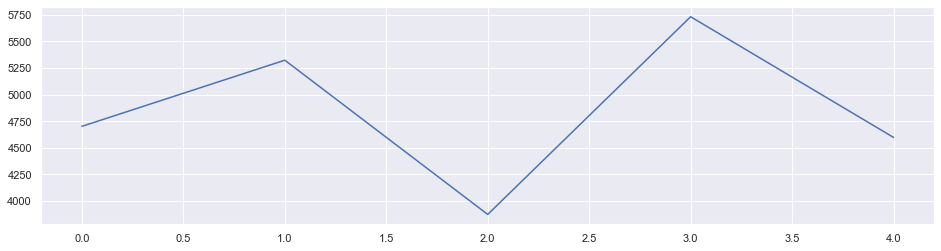

In [56]:
return_trace,expanded=main(total_trials=total_trials, num_episodes=num_episodes, optimization_strategy="GridSearch")

In [57]:
path=r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\results\output\transitions\sQ'

In [58]:
file=newest(path)
file

'C:\\Users\\kishore.kukreja\\Desktop\\Inventory Policy Two Echelon\\SCM-RL\\results\\output\\transitions\\sQ\\transitions-2021-10-17-01-24.csv'

In [59]:
transitions_all = pd.read_csv(file)
transitions_all.describe()

,episode,t,factory_stock,warehouse_stock_0,warehouse_stock_1,warehouse_stock_2,production_level,shipping_to_warehouse_0,shipping_to_warehouse_1,shipping_to_warehouse_2,timestep_reward,total_reward
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.00000,150.000000,150.000000,150.000000,150.000000,150.000000,150.00000
mean,2.000000,14.500000,5.066667,4.346667,4.366667,4.78000,7.866667,2.666667,2.633333,2.300000,161.526667,1282.36000
std,1.418951,8.684438,5.277109,1.839122,1.770059,1.65424,4.110335,2.502795,2.504805,2.500336,372.479984,2109.39787
min,0.000000,0.000000,-10.000000,-1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-1127.000000,-2218.00000
25%,1.000000,7.000000,5.000000,3.000000,3.000000,4.00000,10.000000,0.000000,0.000000,0.000000,-24.250000,-515.75000
50%,2.000000,14.500000,5.000000,4.000000,4.000000,5.00000,10.000000,5.000000,5.000000,0.000000,173.500000,980.50000
75%,3.000000,22.000000,10.000000,6.000000,6.000000,6.00000,10.000000,5.000000,5.000000,5.000000,440.750000,2886.75000
max,4.000000,29.000000,10.000000,8.000000,8.000000,8.00000,10.000000,5.000000,5.000000,5.000000,970.000000,5779.00000


In [60]:
transitions_all.head()

,episode,t,factory_stock,warehouse_stock_0,warehouse_stock_1,warehouse_stock_2,production_level,shipping_to_warehouse_0,shipping_to_warehouse_1,shipping_to_warehouse_2,timestep_reward,total_reward
0,0,0,-5.0,3.0,2.0,4.0,10,5.0,5.0,5.0,50.0,50.0
1,0,1,-10.0,6.0,6.0,7.0,10,5.0,5.0,5.0,-606.0,-556.0
2,0,2,0.0,3.0,3.0,5.0,10,0.0,0.0,0.0,-716.0,-1272.0
3,0,3,0.0,5.0,7.0,3.0,10,5.0,5.0,0.0,55.0,-1217.0
4,0,4,5.0,4.0,5.0,7.0,10,0.0,0.0,5.0,-161.0,-1378.0


In [61]:
episodes = np.array(transitions_all["episode"].unique())
episode_num = np.random.randint(episodes.shape[0])
transitions = transitions_all[transitions_all["episode"] == episode_num]

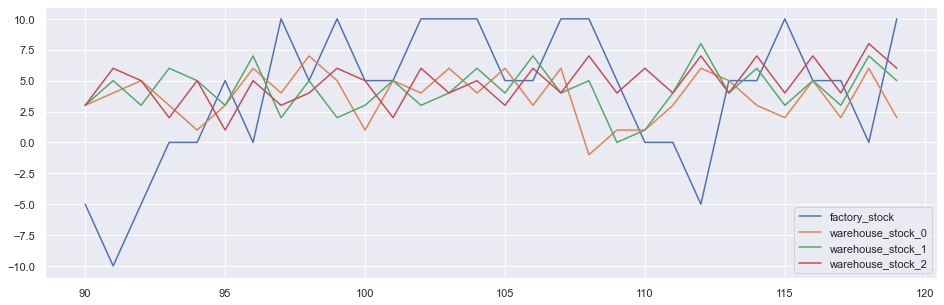

In [62]:
plt.figure(figsize=(16,5))
plt.plot(transitions["factory_stock"])
plt.plot(transitions["warehouse_stock_0"])
plt.plot(transitions["warehouse_stock_1"])
plt.plot(transitions["warehouse_stock_2"])
plt.legend(["factory_stock", "warehouse_stock_0", "warehouse_stock_1","warehouse_stock_2"])

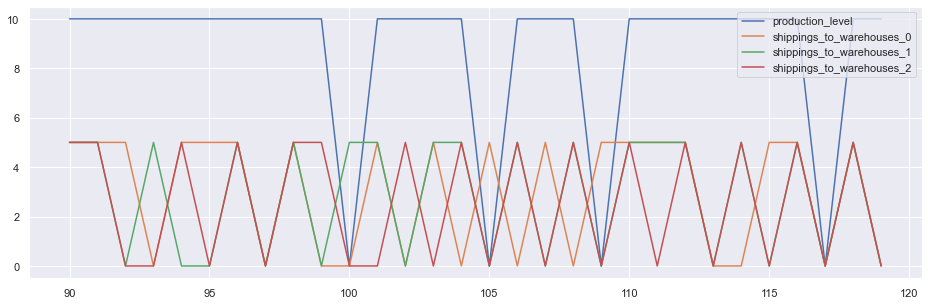

In [63]:
plt.figure(figsize=(16, 5))
plt.plot(transitions["production_level"])
plt.plot(transitions["shipping_to_warehouse_0"])
plt.plot(transitions["shipping_to_warehouse_1"])
plt.plot(transitions["shipping_to_warehouse_2"])
plt.legend(["production_level", "shippings_to_warehouses_0",
           "shippings_to_warehouses_1","shippings_to_warehouses_2"])

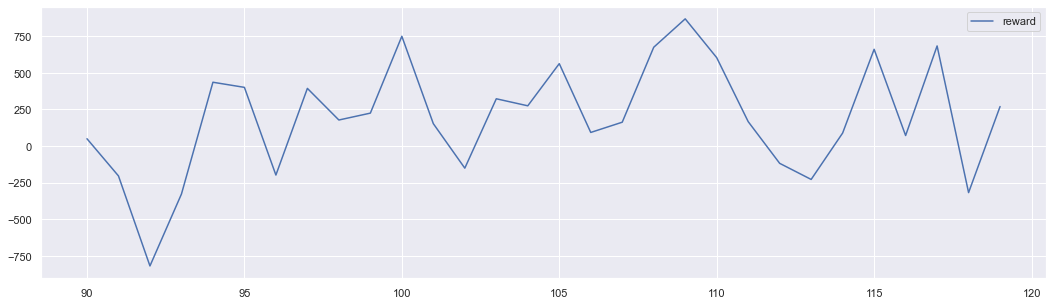

In [64]:
plt.figure(figsize=(18, 5))
plt.plot(transitions["timestep_reward"])
plt.legend(["reward"])

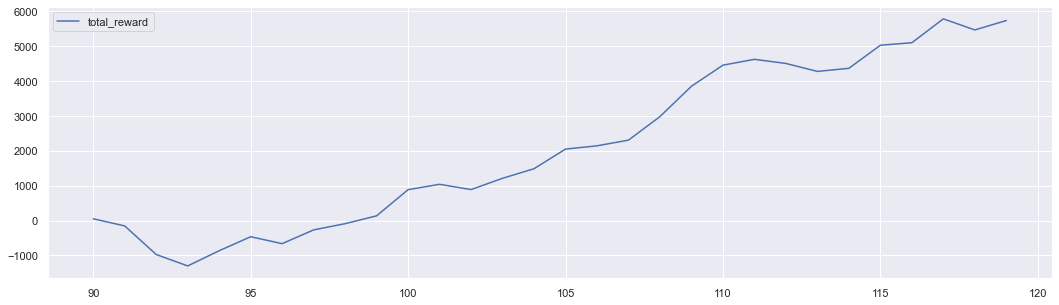

In [65]:
plt.figure(figsize=(18, 5))
plt.plot(transitions["total_reward"])
plt.legend(["total_reward"])

#### Baseline Using Bayesian Optimization

In [66]:
total_trials=5
num_episodes=5
optimization_strategy="BayesianOptimization" ## "GridSearch","BayesianOptimization"

[INFO 10-17 01:26:19] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 10-17 01:26:19] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 16 trials, GPEI for subsequent trials]). Iterations after 16 will take longer to generate due to  model-fitting.
[INFO 10-17 01:26:19] ax.service.managed_loop: Started full optimization with 5 steps.
[INFO 10-17 01:26:19] ax.service.managed_loop: Running optimization trial 1...
[INFO 10-17 01:26:19] ax.service.managed_loop: Running optimization trial 2...
[INFO 10-17 01:26:19] ax.service.managed_loop: Running optimization trial 3...
[INFO 10-17 01:26:19] ax.service.managed_loop: Running optimization trial 4...
[INFO 10-17 01:26:20] ax.service.managed_loop: Running optimization trial 5...


Best Parameters: 
{'factory_s': 8.336858283728361, 'factory_Q': 9.255598271265626, 'w1_s': 2.440657326951623, 'w1_Q': 6.300342418253422, 'w2_s': 7.0503750536590815, 'w2_Q': 9.347976897843182, 'w3_s': 7.30469954200089, 'w3_Q': 7.22882614005357}
Best Values: 
({'objective': -5146.037614959292}, {'objective': {'objective': nan}})
Reward: mean -5339.5223391378295, standard deviation 2952.84118449937


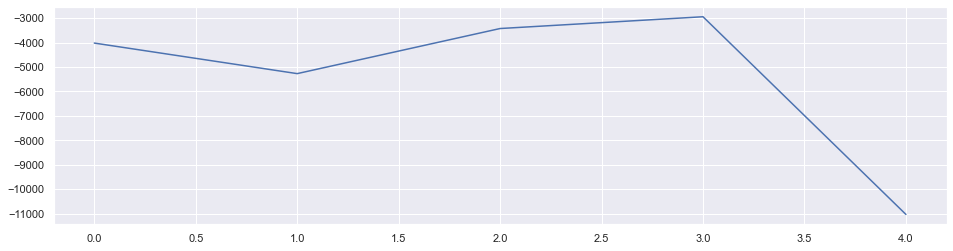

In [68]:
return_trace,expanded=main(total_trials=total_trials, num_episodes=num_episodes, optimization_strategy='BayesianOptimization')

In [69]:
path=r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\results\output\transitions\sQ'

In [70]:
file=newest(path)
file

'C:\\Users\\kishore.kukreja\\Desktop\\Inventory Policy Two Echelon\\SCM-RL\\results\\output\\transitions\\sQ\\transitions-2021-10-17-01-26.csv'

In [72]:
transitions_all = pd.read_csv(file)
transitions_all.describe()

,episode,t,factory_stock,warehouse_stock_0,warehouse_stock_1,warehouse_stock_2,production_level,shipping_to_warehouse_0,shipping_to_warehouse_1,shipping_to_warehouse_2,timestep_reward,total_reward
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,2.000000,14.500000,1.609651,3.296913,8.899931,8.443180,8.885374,2.562139,2.929033,2.457801,-177.984078,-6068.915402
std,1.418951,8.684438,9.061491,1.992343,2.993290,2.221748,1.819796,3.105169,4.350572,3.435830,613.098266,3088.640273
min,0.000000,0.000000,-20.942752,-1.399315,0.347977,2.915305,0.000000,0.000000,0.000000,0.000000,-2049.039149,-12731.421870
25%,1.000000,7.000000,-5.122016,1.727825,6.750867,6.493685,9.255598,0.000000,0.000000,0.000000,-345.238870,-7660.933840
50%,2.000000,14.500000,5.016043,3.300342,8.783815,8.372957,9.255598,0.000000,0.000000,0.000000,-1.179016,-5559.181339
75%,3.000000,22.000000,10.000000,4.876284,11.131792,10.351783,9.255598,6.300342,9.347977,7.228826,186.368584,-4085.411287
max,4.000000,29.000000,10.000000,7.501712,14.479769,13.372957,9.255598,6.300342,9.347977,7.228826,796.362196,796.362196


In [73]:
episodes = np.array(transitions_all["episode"].unique())
episode_num = np.random.randint(episodes.shape[0])
transitions = transitions_all[transitions_all["episode"] == episode_num]

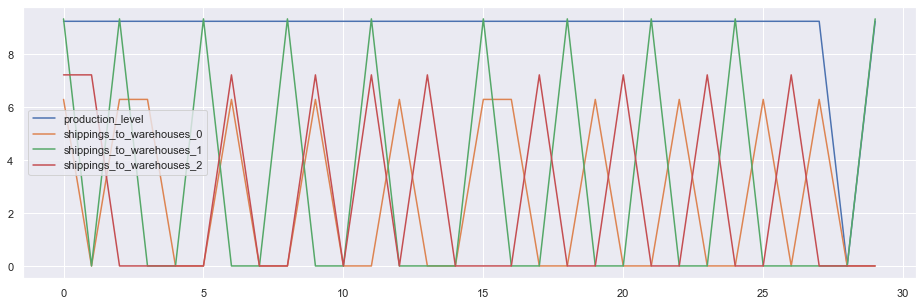

In [74]:
plt.figure(figsize=(16, 5))
plt.plot(transitions["production_level"])
plt.plot(transitions["shipping_to_warehouse_0"])
plt.plot(transitions["shipping_to_warehouse_1"])
plt.plot(transitions["shipping_to_warehouse_2"])
plt.legend(["production_level", "shippings_to_warehouses_0",
           "shippings_to_warehouses_1","shippings_to_warehouses_2"])

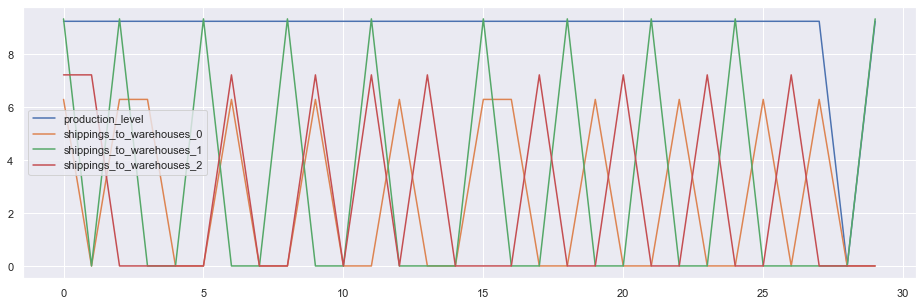

In [75]:
plt.figure(figsize=(16, 5))
plt.plot(transitions["production_level"])
plt.plot(transitions["shipping_to_warehouse_0"])
plt.plot(transitions["shipping_to_warehouse_1"])
plt.plot(transitions["shipping_to_warehouse_2"])
plt.legend(["production_level", "shippings_to_warehouses_0",
           "shippings_to_warehouses_1","shippings_to_warehouses_2"])

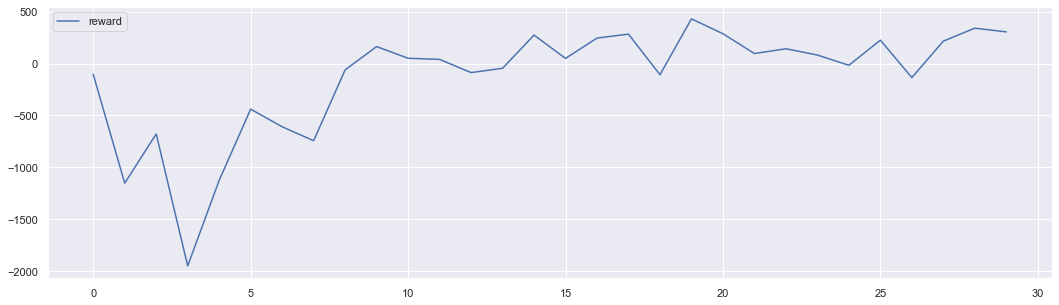

In [76]:
plt.figure(figsize=(18, 5))
plt.plot(transitions["timestep_reward"])
plt.legend(["reward"])

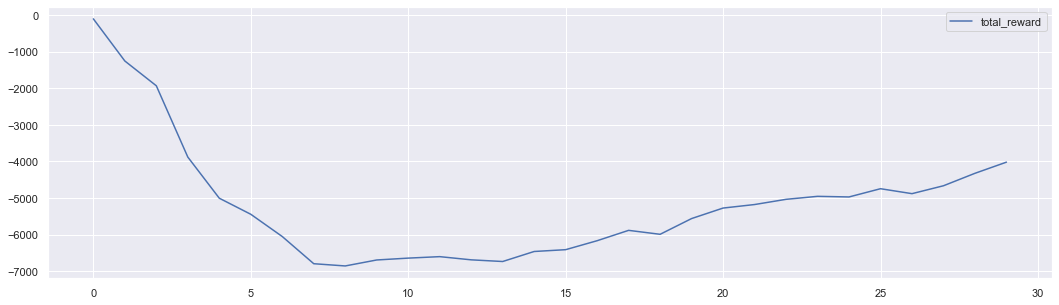

In [77]:
plt.figure(figsize=(18, 5))
plt.plot(transitions["total_reward"])
plt.legend(["total_reward"])

### Policy learnt from RL SB3

#### RL User Defined Functions

In [8]:
def train_agent(initial_state,algorithm="TD3",train=False, timesteps=5e5, filename=None, num_episodes=100):
    '''
    No Initial state is required 
    '''
    print("Creating Agent...")

    if train:
        if algorithm == "TD3":
            agent = train_td3(timesteps, net_architecture=[300, 400])
        elif algorithm == "DDPG":
            agent = train_ddpg(timesteps)
        else:
            print("Invalid Algorithm Entered")
            return
    print('Agent Trained & Saved')

In [9]:
def predict(initial_state,algorithm="TD3",train=False, timesteps=5e5, filename=None, num_episodes=100):
    print("Creating Agent...")

    if train:
        None
    else:
        if algorithm == "TD3":
            agent = load_td3(filename)
        elif algorithm == "DDPG":
            agent = load_ddpg(filename)
        else:
            print("Invalid Algorithm Entered")
            return

    print(f"Starting testing for {num_episodes}...")
    print(f"Initial state of system-factory stock,warehouse 1,warehouse 2,warehouse 3,0,0,0,0,0,0,0,0,0--> {initial_state}")
    mean_reward, total_rewards, _ = test_agent(
        agent,initial_state, log=True, num_episodes=10)
    std_dev = np.std(total_rewards)

    print(
        f">> Reward Mean: {mean_reward} [std. dev: {std_dev}] (episodes: {num_episodes}")

    plt.plot(total_rewards)
    plt.show()

#### RL Using TD3

##### TD3 Train Agent

In [10]:
warehouses=3
agent='TD3'
train=True
steps=30
file=None
episodes=5
initial_state=[100,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [11]:
train_agent(initial_state,algorithm=agent, train=train, timesteps=steps,
         filename=file, num_episodes=episodes)

Creating Agent...
Created Environment...
0
3
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting Model Training...
3
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Logging to ./tensorboard/TD3\TD3_9
3
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training Finished. Model saved as >>> ./results/model/TD3/td3_1634429729
Agent Trained & Saved


##### TD3 Predict using Agent

In [12]:
path=r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\results\model\TD3'

In [13]:
file=newest(path)
file

'C:\\Users\\kishore.kukreja\\Desktop\\Inventory Policy Two Echelon\\SCM-RL\\results\\model\\TD3\\td3_1634429729.zip'

In [14]:
warehouses=3
agent='TD3'
train=False
steps=30
#file=r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\results\model\TD3\td3_1634428296.zip'
episodes=5
initial_state=[100,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0]

Creating Agent...
Starting testing for 5...
Initial state of system-factory stock,warehouse 1,warehouse 2,warehouse 3,0,0,0,0,0,0,0,0,0--> [100, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0
3
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
starts here
3
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
warehouses: 3
[100, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
obs [-15.60646689   5.44147873   3.8440485   -1.65930104   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.        ]
reward 683.4512555599213
obs [-22.30951846   8.64498949   4.06400585  -0.54690504   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           3.           3.
   2.           1.        ]
reward -1264.6225588321686
obs [-27.94648993  13.13256359   6.55648708  -1.49653482   0.
   0.           0.           0.           0.           0.
   3.           3. 

obs [-34.23376095  20.           9.63146257  -1.76864433   2.
   2.           2.           3.           3.           2.
   3.           2.           2.           2.           1.
   1.           4.        ]
reward -2744.6849279403687
obs [-37.27977574  20.          10.24082541  -2.78155863   3.
   3.           2.           3.           2.           2.
   2.           1.           1.           2.           4.
   3.           5.        ]
reward -3453.602245926857
obs [-39.62280762  20.          12.48426223  -4.0654434    3.
   2.           2.           2.           1.           1.
   2.           4.           3.           2.           3.
   2.           6.        ]
reward -3875.1231586933136
obs [-42.46466458  20.          14.31754708  -4.37787759   2.
   1.           1.           2.           4.           3.
   2.           3.           2.           3.           2.
   2.           7.        ]
reward -4457.692901134491
obs [-44.9238168   20.          15.37742186  -5.76634645   2.
   4.   

obs [-44.69982827  20.          15.75340533  -8.99334598   3.
   3.           2.           2.           4.           1.
   2.           3.           2.           3.           2.
   2.          10.        ]
reward -5083.339195907116
obs [-46.22867405  20.          17.02251029 -10.53422809   2.
   4.           1.           2.           3.           2.
   3.           2.           2.           2.           2.
   2.          11.        ]
reward -5282.860583305359
obs [-46.89134228  20.          16.98484397 -12.13634413   2.
   3.           2.           3.           2.           2.
   2.           2.           2.           3.           2.
   2.          12.        ]
reward -5596.3533167243
obs [-47.229725    20.          17.09408951 -13.75247294   3.
   2.           2.           2.           2.           2.
   3.           2.           2.           2.           3.
   2.          13.        ]
reward -5724.621667027473
obs [-47.45497429  20.          18.22380447 -17.34746295   2.
   2.       

obs [-51.76791108  20.          23.48806334 -17.19949126   2.
   3.           1.           2.           2.           2.
   3.           3.           1.           2.           1.
   2.          17.        ]
reward -6739.042414665222
obs [-50.11912024  20.          23.35215986 -18.95107669   2.
   2.           2.           3.           3.           1.
   2.           1.           2.           2.           1.
   3.          18.        ]
reward -6954.748508155346
obs [-47.95915711  20.          21.31695604 -20.69134676   3.
   3.           1.           2.           1.           2.
   2.           1.           3.           2.           2.
   2.          19.        ]
reward -6760.403687655926
obs [-46.07224333  20.          21.76814818 -22.39380932   2.
   1.           2.           2.           1.           3.
   2.           2.           2.           2.           4.
   2.          20.        ]
reward -6911.5636566877365
obs [-43.50853217  20.          20.69079077 -25.04490101   2.
   1.    

obs [-27.86141551  19.92713761  14.32996929 -37.40626329   3.
   3.           2.           3.           2.           2.
   2.           3.           3.           1.           2.
   1.          23.        ]
reward -6664.958679437637
obs [-22.72297823  17.54573774  15.50659716 -38.89941043   3.
   2.           2.           2.           3.           3.
   1.           2.           1.           2.           4.
   2.          24.        ]
reward -6407.539053440094
obs [-17.15624821  17.97101295  16.16666818 -39.35803962   2.
   3.           3.           1.           2.           1.
   2.           4.           2.           4.           1.
   2.          25.        ]
reward -6425.04693287611
obs [-12.3004452   17.23272741  16.04237986 -40.83927536   1.
   2.           1.           2.           4.           2.
   4.           1.           2.           1.           1.
   1.          26.        ]
reward -5593.639733076096
obs [ -7.7330631   16.27934086  15.87634301 -41.25815839   2.
   4.      

obs [ -1.14979041  14.55396986  14.45843756 -42.82897872   1.
   2.           1.           2.           4.           2.
   4.           1.           2.           1.           1.
   1.          28.        ]
reward -4455.003079175949
obs [  1.90834129  13.60854745  14.09298587 -43.31352311   2.
   4.           2.           4.           1.           2.
   1.           1.           1.           2.           2.
   2.          29.        ]
reward -4322.702159523964
3
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
warehouses: 3
[100, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
obs [-15.60646689   5.44147873   4.8440485   -1.65930104   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.        ]
reward 583.4512555599213
obs [-21.89240277   9.54023933   4.8659749   -0.56476474   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           3.           2.

obs [-35.43122923  20.           8.15239787  -4.94534445   1.
   2.           2.           3.           4.           2.
   2.           4.           3.           2.           2.
   2.           4.        ]
reward -3022.1788206100464
obs [-38.62784064  20.           9.84825182  -6.99930876   3.
   4.           2.           2.           4.           3.
   2.           2.           2.           2.           3.
   4.           5.        ]
reward -3996.926128566265
obs [-40.52118933  20.           8.03327513 -11.28324389   2.
   4.           3.           2.           2.           2.
   2.           3.           4.           1.           2.
   3.           6.        ]
reward -3937.372618496418
obs [-42.78708422  18.87438154   9.67927408 -12.66140115   2.
   2.           2.           2.           3.           4.
   1.           2.           3.           1.           6.
   5.           7.        ]
reward -4548.855612397194
obs [-44.61623442  20.           9.95282602 -14.0198403    2.
   3.    

obs [-59.48626387  20.          15.77776742 -11.01878852   2.
   2.           2.           3.           2.           1.
   2.           3.           2.           3.           2.
   2.          11.        ]
reward -6424.94788557291
obs [-61.15447104  20.          14.7863481  -14.81650645   3.
   2.           1.           2.           3.           2.
   3.           2.           2.           2.           3.
   3.          12.        ]
reward -6680.748369812965
obs [-62.66309798  20.          15.05277205 -17.62568426   2.
   3.           2.           3.           2.           2.
   2.           3.           3.           2.           4.
   4.          13.        ]
reward -7427.905538737774
obs [-64.10364687  20.          16.46146131 -18.46745837   3.
   2.           2.           2.           3.           3.
   2.           4.           4.           2.           3.
   3.          14.        ]
reward -8063.176354050636
obs [-65.46489394  20.          17.60859275 -20.31042367   2.
   3.      

obs [-38.39431441  20.          20.46608186 -17.81596917   2.
   3.           2.           3.           2.           1.
   2.           2.           2.           2.           2.
   2.          17.        ]
reward -5857.329458534718
obs [-36.55447018  20.          20.76803708 -19.35512066   3.
   2.           1.           2.           2.           2.
   2.           2.           2.           2.           2.
   1.          18.        ]
reward -5552.8849220871925
obs [-34.27684748  20.          20.9484272  -21.76692057   2.
   2.           2.           2.           2.           2.
   2.           2.           1.           3.           2.
   2.          19.        ]
reward -5525.97122335434
obs [-31.04328692  20.          20.97624969 -23.14664125   2.
   2.           2.           2.           2.           1.
   3.           2.           2.           2.           2.
   3.          20.        ]
reward -5632.3531930446625
obs [-27.16064751  20.          19.9636476  -24.43999571   2.
   2.    

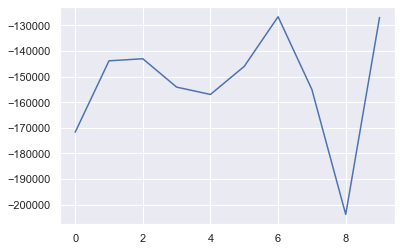

In [15]:
predict(initial_state,algorithm=agent, train=train, timesteps=steps,
         filename=file, num_episodes=episodes)

In [16]:
path=r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\results\output\transitions\RL'
file=newest(path)

In [17]:
transitions = pd.read_csv(file)
episodes = np.array(transitions["episode"].unique())
episode_num = 9 # np.random.randint(episodes.shape[0])
transitions = transitions[transitions["episode"] == episode_num]

In [18]:
transitions.head()

,episode,t,factory_stock,warehouse_0,warehouse_1,warehouse_2,production_level,shipping_to_warehouse_0,shipping_to_warehouse_1,shipping_to_warehouse_2,timestep_reward,total_reward
270,9,0,-15.606467,7.441479,4.844049,-2.659301,0.019760,8.441479,6.844049,0.340699,483.451256,483.451256
271,9,1,-21.327416,8.970971,6.917044,-2.588798,6.952042,5.529492,4.072995,3.070504,-1377.923628,-894.472372
272,9,2,-25.567005,12.539846,9.993689,-1.493956,7.500773,5.568875,4.076645,2.094841,-2469.071898,-3363.544270
273,9,3,-29.009041,16.680236,10.436238,-1.775456,7.859403,6.140390,3.442549,1.718500,-2521.498649,-5885.042918
274,9,4,-32.419479,20.000000,10.317445,-2.199470,8.009809,6.963054,2.881207,1.575986,-2815.447647,-8700.490566


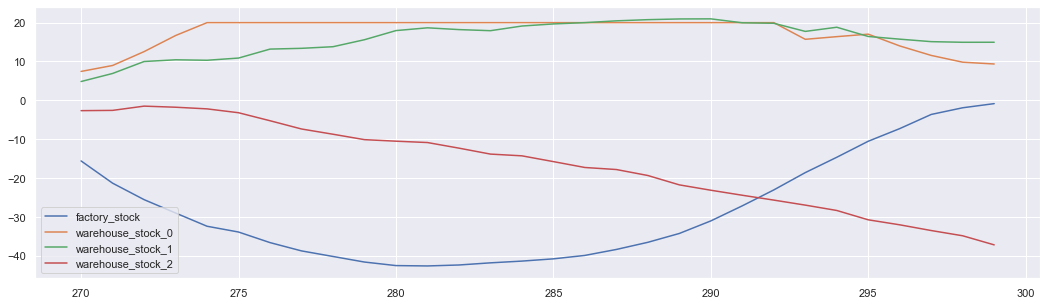

In [19]:
plt.figure(figsize=(18, 5))
plt.plot(transitions["factory_stock"])
plt.plot(transitions["warehouse_0"])
plt.plot(transitions["warehouse_1"])
plt.plot(transitions["warehouse_2"])
plt.legend(["factory_stock", "warehouse_stock_0", "warehouse_stock_1","warehouse_stock_2"])

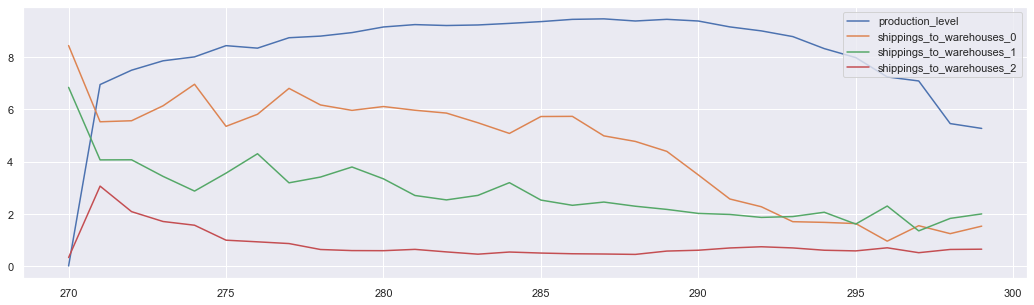

In [20]:
plt.figure(figsize=(18, 5))
plt.plot(transitions["production_level"])
plt.plot(transitions["shipping_to_warehouse_0"])
plt.plot(transitions["shipping_to_warehouse_1"])
plt.plot(transitions["shipping_to_warehouse_2"])

plt.legend(["production_level", "shippings_to_warehouses_0",
           "shippings_to_warehouses_1","shippings_to_warehouses_2"])

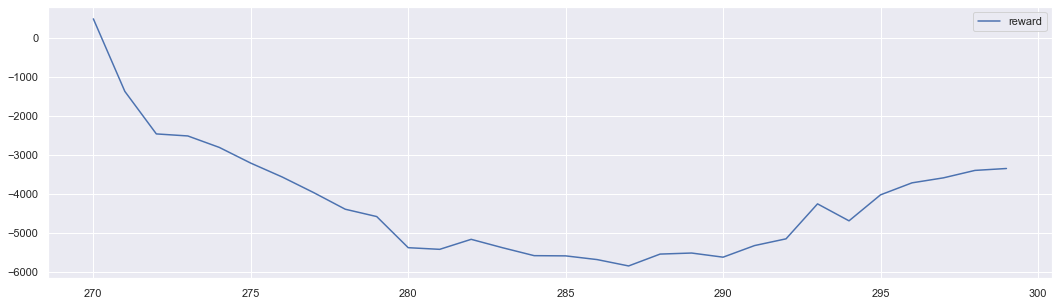

In [21]:
plt.figure(figsize=(18, 5))
plt.plot(transitions["timestep_reward"])
plt.legend(["reward"])

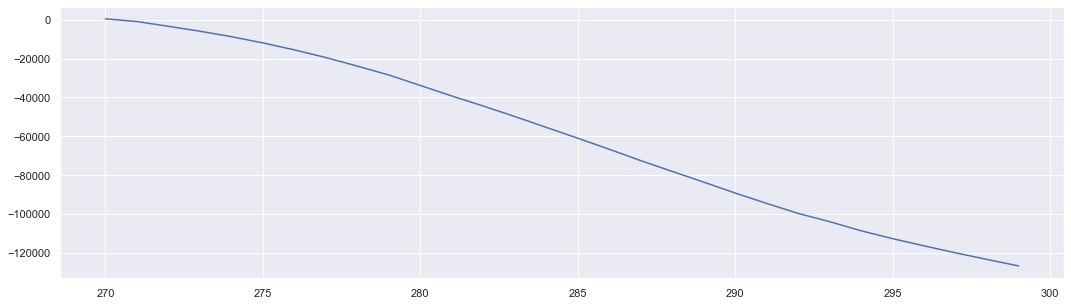

In [22]:
plt.figure(figsize=(18, 5))
plt.plot(transitions["total_reward"])

In [23]:
print(f"Max Rewards: {transitions['total_reward'].iloc[-1]}")

Max Rewards: -126879.058267951


#### RL Using DDPG

##### DDPG Train Agent

In [33]:
warehouses=3
agent='DDPG'
train=True
steps=30
file=None
episodes=5
initial_state=[100,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0]
#[factory stock, warehouse stock1,2,..N, demand vector of 4 length *N warehouses, t]

In [34]:
train_agent(initial_state,algorithm=agent, train=train, timesteps=steps,
         filename=file, num_episodes=episodes)

Creating Agent...
Created Environment...
0
3
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting Model Training...
3
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Logging to ./tensorboard/DDPG\DDPG_16
3
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training Finished. Model saved as >>> ./results/model/DDPG/ddpg_1634429951
Agent Trained & Saved


##### DDPG Predict using Agent

In [35]:
path=r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\results\model\DDPG'

In [39]:
file=newest(path)
file

'C:\\Users\\kishore.kukreja\\Desktop\\Inventory Policy Two Echelon\\SCM-RL\\results\\model\\DDPG\\ddpg_1634429951.zip'

In [40]:
warehouses=3
agent='DDPG'
train=False
steps=30
#file='C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\results\model\DDPG\ddpg_1634428806.zip'
episodes=5
initial_state=[100,10,10,10,0,0,0,0,0,0,0,0,0,0,0,0,0]
#[factory stock, warehouse stock1,2,..N, demand vector of 4 length(in env py file) *N warehouses, t]

Creating Agent...
Starting testing for 5...
Initial state of system-factory stock,warehouse 1,warehouse 2,warehouse 3,0,0,0,0,0,0,0,0,0--> [100, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0
3
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2
starts here
3
1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
warehouses: 3
[100, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
obs [-17.87727988  -1.58802938   6.61202431   7.60121727   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.        ]
reward 387.88437128067017
obs [-29.51194489   2.09033918   8.81355286   9.16892576   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           2.           3.
   2.           1.        ]
reward -1448.4531707763672
obs [-44.70698559   6.59685326  13.76412487  10.15925407   0.
   0.           0.           0.           0.           0.
   2.           3.

obs [-92.71072137  20.          30.          11.5800125    2.
   2.           1.           4.           4.           3.
   3.           3.           2.           1.           3.
   3.           5.        ]
reward -7363.95037060976
obs [-111.87317801   20.           30.           10.00065649    4.
    4.            3.            3.            3.            2.
    1.            3.            3.            2.            4.
    1.            6.        ]
reward -9098.708835422993
obs [-131.44452095   20.           30.            8.27324998    3.
    3.            2.            1.            3.            3.
    2.            4.            1.            2.            3.
    2.            7.        ]
reward -10891.728713035583
obs [-151.22548884   20.           30.            5.44642055    1.
    3.            3.            2.            4.            1.
    2.            3.            2.            5.            1.
    2.            8.        ]
reward -12527.305227279663
obs [-171.05048001  

obs [-196.29039204   20.           30.            0.92753953    7.
    2.            2.            2.            2.            2.
    2.            2.            3.            3.            2.
    1.           10.        ]
reward -17077.77342927456
obs [-216.28949654   20.           30.           -1.00856221    2.
    2.            2.            2.            2.            3.
    3.            2.            1.            3.            4.
    3.           11.        ]
reward -19448.345647633076
obs [-236.30728275   20.           30.           -2.94963765    2.
    2.            3.            3.            2.            1.
    3.            4.            3.            2.            2.
    2.           12.        ]
reward -21341.1641651392
obs [-256.32329309   20.           30.           -3.90596563    3.
    2.            1.            3.            4.            3.
    2.            2.            2.            2.            4.
    2.           13.        ]
reward -23836.70258551836
obs 

obs [-249.06165361   20.           30.           -3.45262808    3.
    1.            2.            4.            2.            2.
    1.            2.            2.            2.            2.
    2.           13.        ]
reward -23065.397891402245
obs [-269.07247704   20.           30.           -5.42202616    4.
    2.            2.            1.            2.            2.
    2.            2.            2.            1.            1.
    2.           14.        ]
reward -24962.093127071857
obs [-289.0818699    20.           30.           -8.40171409    1.
    2.            2.            2.            2.            2.
    1.            1.            2.            2.            3.
    2.           15.        ]
reward -26759.85906124115
obs [-309.09230298   20.           30.           -9.3837859     2.
    2.            2.            1.            1.            2.
    2.            3.            2.            5.            3.
    3.           16.        ]
reward -29558.70520800352
ob

obs [-334.24750674   20.           30.          -16.72801024    4.
    3.            3.            2.            3.            3.
    2.            3.            3.            3.            1.
    2.           17.        ]
reward -32508.124931156635
obs [-354.253362     20.           30.          -18.71939707    2.
    3.            3.            2.            3.            3.
    3.            1.            2.            4.            2.
    2.           18.        ]
reward -35007.714323699474
obs [-374.25845045   20.           30.          -19.71222395    2.
    3.            3.            3.            1.            2.
    4.            2.            2.            1.            2.
    2.           19.        ]
reward -36907.40716904402
obs [-394.26325965   20.           30.          -21.70628673    3.
    1.            2.            4.            2.            2.
    1.            2.            2.            4.            3.
    1.           20.        ]
reward -39207.168759703636
o

obs [-409.25449032   20.           30.          -24.13374037    2.
    1.            1.            3.            2.            2.
    3.            3.            3.            2.            2.
    3.           21.        ]
reward -40949.00005578995
obs [-429.25735629   20.           30.          -25.13035721    3.
    2.            2.            3.            3.            3.
    2.            2.            3.            2.            2.
    2.           22.        ]
reward -43248.87992620468
obs [-449.25909609   20.           30.          -27.12828535    3.
    3.            3.            2.            2.            3.
    2.            2.            2.            2.            2.
    1.           23.        ]
reward -44948.80590081215
obs [-469.26061678   20.           30.          -29.12654519    2.
    2.            3.            2.            2.            2.
    2.            2.            1.            3.            4.
    2.           24.        ]
reward -47148.766732513905
obs

obs [-504.57085884   20.           30.          -37.53890157    3.
    2.            2.            2.            3.            2.
    7.            4.            2.            3.            5.
    3.           26.        ]
reward -51121.01696997881
obs [-524.57201964   20.           30.          -39.53767043    2.
    3.            2.            7.            4.            2.
    3.            5.            3.            5.            4.
    3.           27.        ]
reward -53920.99557310343
obs [-544.57261294   20.           30.          -41.53701985    7.
    4.            2.            3.            5.            3.
    5.            4.            3.            3.            2.
    2.           28.        ]
reward -56320.97984820604
obs [-564.57294112   20.           30.          -44.53666431    3.
    5.            3.            5.            4.            3.
    3.            2.            2.            2.            1.
    2.           29.        ]
reward -58220.96898883581
3
1


obs [-17.87727988  -1.58802938   5.61202431   7.60121727   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.        ]
reward 487.88437128067017
obs [-29.64246523   2.09941769  10.77261114   9.12806225   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           2.           4.
   2.           1.        ]
reward -1733.3462915420532
obs [-44.61464942   6.77455378  15.74828005  10.18739367   0.
   0.           0.           0.           0.           0.
   2.           4.           2.           2.           2.
   3.           2.        ]
reward -2583.8447890281677
obs [-61.61615288  10.23475456  22.51088572   8.88916612   0.
   0.           0.           2.           4.           2.
   2.           2.           3.           2.           4.
   3.           3.        ]
reward -3856.928679704666
obs [-79.07313621  16.92930984  30.           6.97500086   2.
   4.   

obs [-72.53995812  14.84764099  30.          13.25124812   2.
   2.           2.           3.           2.           3.
   4.           2.           1.           2.           2.
   1.           4.        ]
reward -5826.625305175781
obs [-90.05199206  20.          30.          11.21897811   3.
   2.           3.           4.           2.           1.
   2.           2.           1.           2.           2.
   2.           5.        ]
reward -7143.0114651322365
obs [-108.897111     20.           30.            9.75945783    4.
    2.            1.            2.            2.            1.
    2.            2.            2.            2.            2.
    3.            6.        ]
reward -8839.591727674007
obs [-128.32942557   20.           30.            8.02571595    2.
    2.            1.            2.            2.            2.
    2.            2.            3.            2.            3.
    2.            7.        ]
reward -10592.955787539482
obs [-148.1175338    20.           3

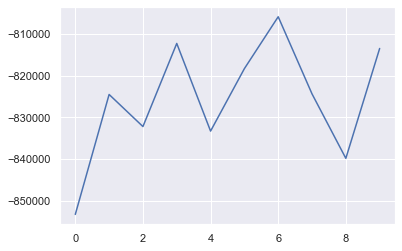

In [41]:
predict(initial_state,algorithm=agent, train=train, timesteps=steps,
         filename=file, num_episodes=episodes)

In [42]:
path=r'C:\Users\kishore.kukreja\Desktop\Inventory Policy Two Echelon\SCM-RL\results\output\transitions\RL'
file=newest(path)

In [43]:
transitions = pd.read_csv(file)
episodes = np.array(transitions["episode"].unique())
episode_num = 9 # np.random.randint(episodes.shape[0])
transitions = transitions[transitions["episode"] == episode_num]

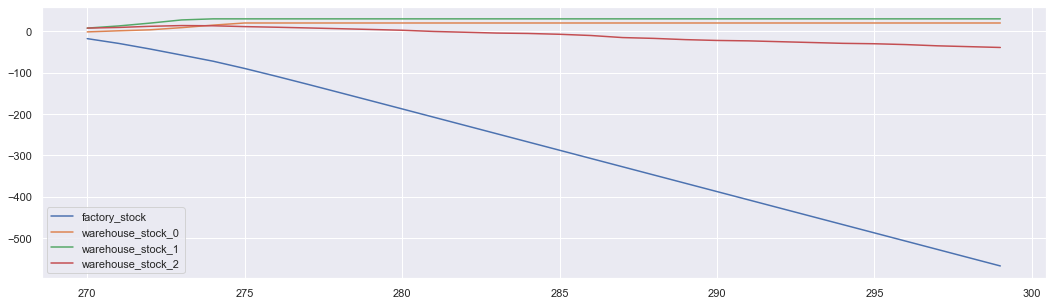

In [44]:
plt.figure(figsize=(18, 5))
plt.plot(transitions["factory_stock"])
plt.plot(transitions["warehouse_0"])
plt.plot(transitions["warehouse_1"])
plt.plot(transitions["warehouse_2"])
plt.legend(["factory_stock", "warehouse_stock_0", "warehouse_stock_1","warehouse_stock_2"])

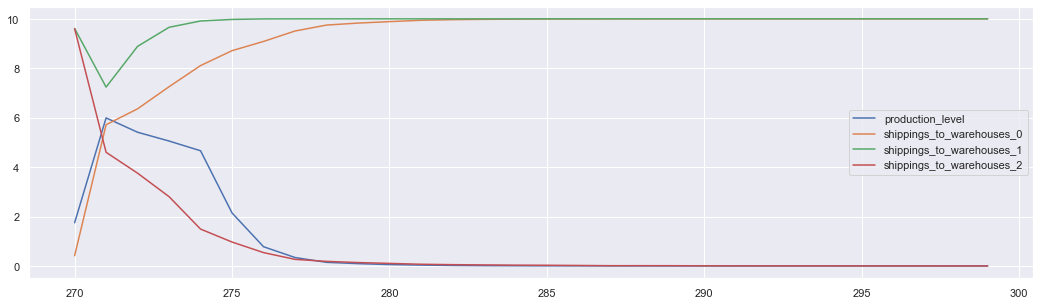

In [45]:
plt.figure(figsize=(18, 5))
plt.plot(transitions["production_level"])
plt.plot(transitions["shipping_to_warehouse_0"])
plt.plot(transitions["shipping_to_warehouse_1"])
plt.plot(transitions["shipping_to_warehouse_2"])


plt.legend(["production_level", "shippings_to_warehouses_0",
           "shippings_to_warehouses_1","shippings_to_warehouses_2"])

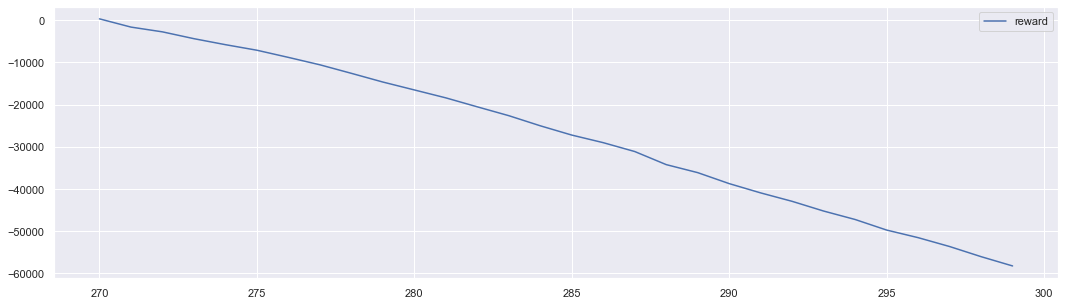

In [46]:
plt.figure(figsize=(18, 5))
plt.plot(transitions["timestep_reward"])
plt.legend(["reward"])

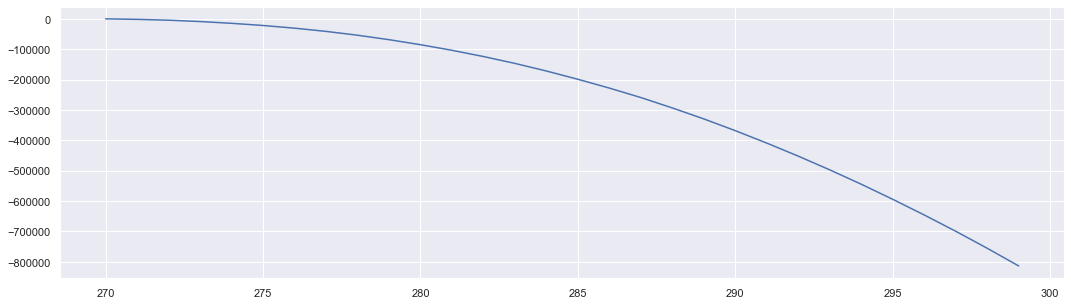

In [47]:
plt.figure(figsize=(18, 5))
plt.plot(transitions["total_reward"])

In [48]:
print(f"Max Rewards: {transitions['total_reward'].iloc[-1]}")

Max Rewards: -813499.271764338
